In [1]:
from rdkit import Chem
from rdkit.Chem import Draw # Added for molecule visualization
from rdkit import RDLogger
from rdkit.Chem import Crippen, Descriptors, MolToSmiles, Draw, QED, rdMolDescriptors
try:
    from rdkit.Chem.SA_Score import sascorer
except ImportError:
    from rdkit.Contrib.SA_Score import sascorer
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split #ML training
import seaborn as sns # Added import

RDLogger.DisableLog('rdApp.*') 
random.seed(42)

In [2]:
from simple_ga import simple_genetic_algorithm, plot_ga_results, dream_smiles, visualize_smiles_list

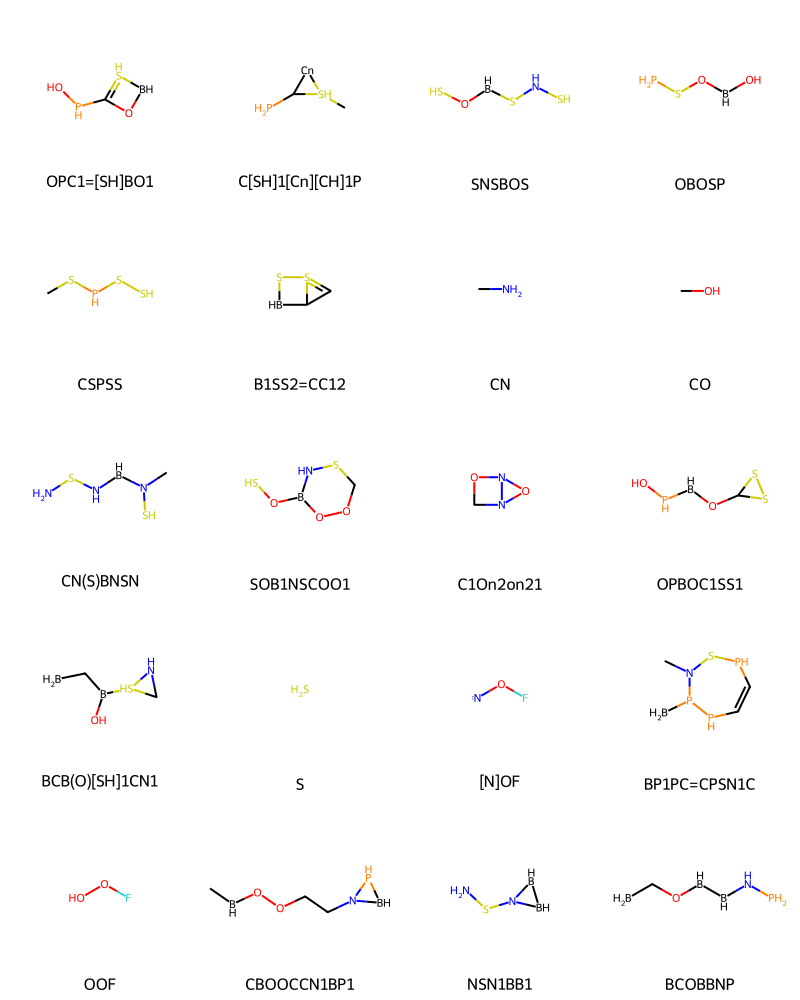

In [3]:
smiles_list = dream_smiles(20)
visualize_smiles_list(smiles_list)

In [4]:
# --- Notes for the user ---
# 1. Fitness Function: The `example_fitness_function` is very basic.
#    For real molecular design, use RDKit or other cheminformatics toolkits to:
#    a. Validate SMILES: `mol = Chem.MolFromSmiles(s)`. If `mol is None`, it's invalid.
#    b. Calculate properties: LogP, QED, molecular weight, presence of specific
#       functional groups, similarity to a target, docking scores, etc.
#    c. The fitness function MUST handle invalid SMILES gracefully (e.g., return
#       a very low score or None, as handled by the GA).
#
# 2. SMILES_CHARS: The `SMILES_CHARS` list is a simplified alphabet.
#    Tailor it to the chemical space you are exploring (e.g., add 'Si', 'B', aromatic lowercase atoms).
#
# 3. Crossover and Mutation: These are simple string manipulations and will
#    often produce invalid SMILES. The fitness function's ability to
#    penalize/filter invalid SMILES is crucial. More advanced, chemically-aware
#    operators exist (e.g., using SELFIES, graph-based methods) but are more complex.
#


In [5]:
# --- User-defined components ---
def example_fitness_function(smiles_string):
    """
    A placeholder fitness function. Scores based on length and presence of 'O'.
    A real fitness function should use cheminformatics toolkits (e.g., RDKit)
    for SMILES validation and property calculation.
    It MUST handle potentially invalid SMILES (e.g., return a very low score or None).
    """
    if not smiles_string: # Handle empty string
        return -1000.0 

    # Using RDKit for validation
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        return -1000.0  # Invalid SMILES

    score = 0.0
    # Reward length within a certain range
    if 5 <= len(smiles_string) <= 30:
        score += len(smiles_string)
    else:
        score -= abs(len(smiles_string) - 15) # Penalize deviation from ideal length 15

    score += smiles_string.count('O') * 10  # Reward Oxygen
    score += smiles_string.count('N') * 5   # Reward Nitrogen
    score -= smiles_string.count('Cl') * 2 # Penalize Chlorine slightly
    
    # Penalize if too short or too long after other calcs
    if len(smiles_string) < 3 or len(smiles_string) > 50:
        return -1000.0

    return score

In [6]:
# --- GA Parameters ---
num_generations = 100
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = dream_smiles(pop_size)

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: 50.0000, SMILES: FOP1#[PH]PSNOO1
Generation 2: New best -> Fitness: 64.0000, SMILES: BBONBN=NN1NON1
Generation 3: New best -> Fitness: 70.0000, SMILES: CN1NBC1SOON1OO1
Generation 4: New best -> Fitness: 95.0000, SMILES: NONBB1ONCOP1OPC1B=[SH]NO1
Generation 5: New best -> Fitness: 134.0000, SMILES: NONBB1ONCOC1BOP(O)NBN=NN1NON1
Generation 6: New best -> Fitness: 137.0000, SMILES: FOP(O)OSOONPPSB1OC1SOON1OO1
Generation 7: New best -> Fitness: 145.0000, SMILES: FOP(O)OSOONPPSB1OC1SONONBB1ONCOC1BOP(O)NBN=NN1NON1
Generation 8: Best this gen -> Fitness: 145.0000, SMILES: FOP(O)OSOONPPSB1OC1SONONBB1ONCOC1BOP(O)NBN=NN1NON1
Generation 9: New best -> Fitness: 154.0000, SMILES: NP(O)BBONBONOBONBONONB1ONCOP1
Generation 10: New best -> Fitness: 159.0000, SMILES: NNNBNPONBB1ONCOP1OP(O)BBONBONOBONBONONB1ONCOP1
Generation 11: Best this gen -> Fitness: 159.0000, SMILES: NNNBNPONBB1ONCOP1OP(O)BBONBONOBONBONONB1

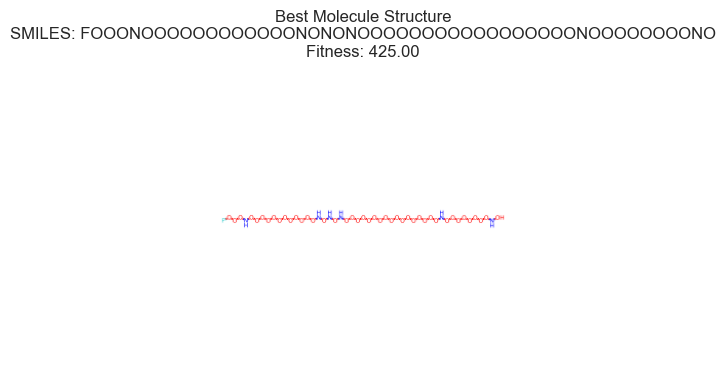

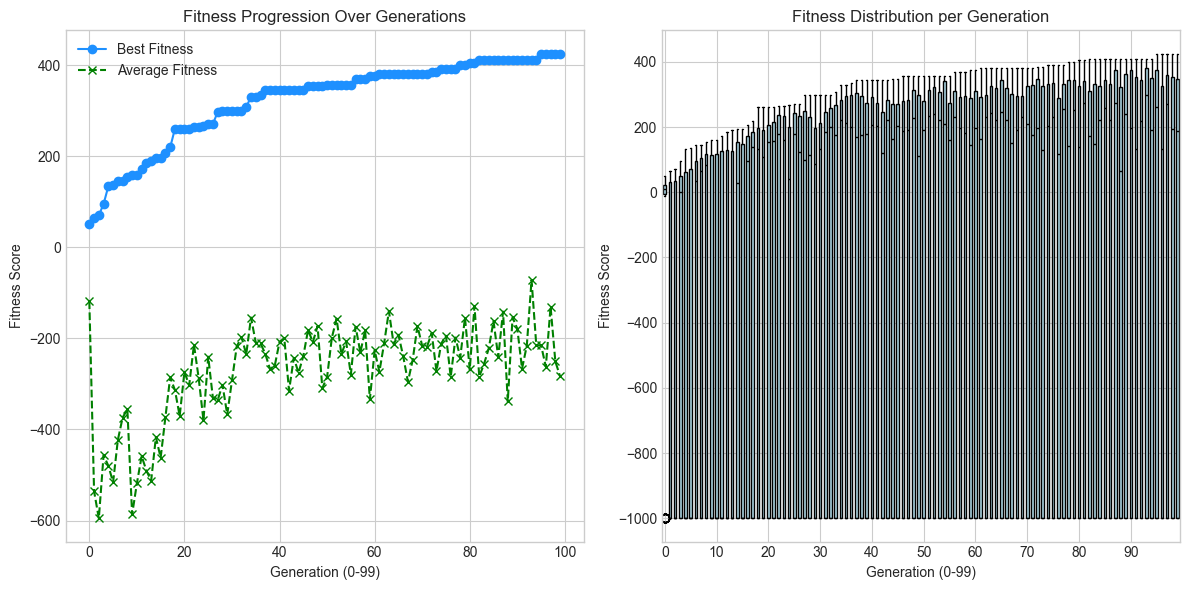

In [7]:
print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=example_fitness_function,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

In [8]:
# Lets do a more interesting example using simple rdkit logp prediction
def rdkit_logp_fitness(smiles):
    """
    Calculates the LogP for a given SMILES string using RDKit.
    Returns a very low score for invalid SMILES.
    """
    if not smiles:
        return -1000.0 # Penalize empty SMILES

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0  # Invalid SMILES, return a very low fitness
    try:
        logp = Crippen.MolLogP(mol)
        # Penalize if too short or too long after other calcs
        if len(smiles) < 3 or len(smiles) > 50:
            return -1000.0
        return logp
    except Exception: # Catch any other RDKit errors during calculation
        return -1000.0

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: 2.5815, SMILES: N1PP2PS[SH]12
Generation 2: New best -> Fitness: 3.4366, SMILES: PB(S)SSSNP(F)S
Generation 3: New best -> Fitness: 3.7719, SMILES: P(F)N1PP2PS[SH]12
Generation 4: New best -> Fitness: 5.2426, SMILES: P(F)N1PP2PS[SH]12P1PSNOO1
Generation 5: New best -> Fitness: 6.0725, SMILES: PB(S)SSSNP(F)S(F)SPPS
Generation 6: Best this gen -> Fitness: 6.0725, SMILES: PB(S)SSSNP(F)S(F)SPPS
Generation 7: New best -> Fitness: 6.7138, SMILES: NP(F)CPPSSPP(F)SPS
Generation 8: New best -> Fitness: 9.6035, SMILES: PB(S)SSSNP(F)S(F)B(S)SSSNP(F)S(F)SPPS
Generation 9: New best -> Fitness: 13.2049, SMILES: PSNP(F)CPPNSN1PP2PS[SH]12P(F)CPPSSPP(F)SPS
Generation 10: New best -> Fitness: 14.1131, SMILES: PP(F)CPPSSPP(F)SPS(F)(F)CPPSPP(F)SPS
Generation 11: New best -> Fitness: 17.2969, SMILES: [P]PSPSSSNP(F)PSSPP(F)SPS(F)(F)CPPSPP(F)SPS
Generation 12: Best this gen -> Fitness: 17.2969, SMILES: [P]PSPSSSNP(F)

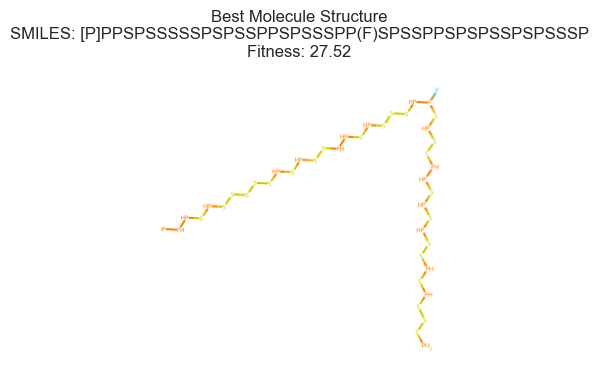

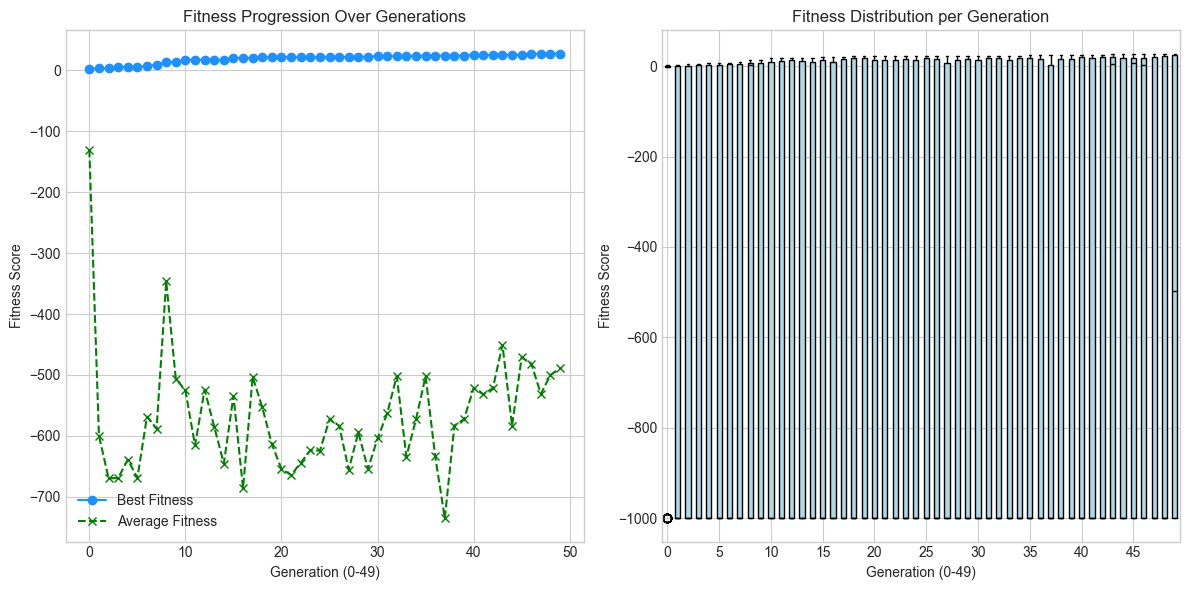

In [9]:
# --- GA Parameters ---
num_generations = 50
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = initial_pop

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_logp_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)


In [10]:
def rdkit_logp_fitness_2(smiles):
    """
    Calculates a fitness score based on LogP, molecular weight,
    ring presence, and connectivity for a given SMILES string using RDKit.
    Returns a very low score for invalid or highly undesirable SMILES.
    """
    if not smiles:
        return -1000.0 # Penalize empty SMILES

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0  # Invalid SMILES, return a very low fitness

    fitness_score = 0.0

    try:
        # 1. Base score from LogP
        fitness_score += Crippen.MolLogP(mol)

        # 2. Check for connected molecule
        frags = Chem.GetMolFrags(mol, asMols=False) # Get fragment indices
        if len(frags) > 1:
            return -1000.0

        # 3. Molecular weight constraint (< 500 Da)
        mw = Descriptors.MolWt(mol)
        if mw < 500:
            fitness_score += 10 # Bonus for being under 500 Da
        else:
            fitness_score -= (mw - 500) / 10 # Penalize proportionally for exceeding 500 Da

        # 4. Ring presence (at least one ring)
        if mol.GetRingInfo().NumRings() > 0:
            fitness_score += 10*mol.GetRingInfo().NumRings()   # Bonus for having at least one ring
        else:
            fitness_score -= 10   # Penalty for no rings
            
        # Penalize if too short or too long after other calcs
        if len(smiles) < 3 or len(smiles) > 100:
            return -1000.0
        return fitness_score
    except Exception: # Catch any other RDKit errors during calculation
        return -1000.0

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: 32.5815, SMILES: N1PP2PS[SH]12
Generation 2: New best -> Fitness: 34.1518, SMILES: FOP1#[PH]PSNOPP2PB12
Generation 3: Best this gen -> Fitness: 34.1518, SMILES: FOP1#[PH]PSNOPP2PB12
Generation 4: Best this gen -> Fitness: 34.1518, SMILES: FOP1#[PH]PSNOPP2PB12
Generation 5: New best -> Fitness: 41.9159, SMILES: C1=PCNP1OC1=PCNP1OPC1B=[SH]NO1
Generation 6: New best -> Fitness: 43.7944, SMILES: N1PP2PS[SH]PN2SCN2SC12
Generation 7: New best -> Fitness: 55.5295, SMILES: C1=PCNP1OC1=PCNP1OC1PSP2PS[SH]C12
Generation 8: New best -> Fitness: 66.2666, SMILES: N1P2PS[SH]C12C1=PCNP1OC1PSP2PS[SH]C12
Generation 9: Best this gen -> Fitness: 66.2666, SMILES: N1P2PS[SH]C12C1=PCNP1OC1PSP2PS[SH]C12
Generation 10: Best this gen -> Fitness: 66.2666, SMILES: N1P2PS[SH]C12C1=PCNP1OC1PSP2PS[SH]C12
Generation 11: Best this gen -> Fitness: 66.2666, SMILES: N1P2PS[SH]C12C1=PCNP1OC1PSP2PS[SH]C12
Generation 12: Best this 

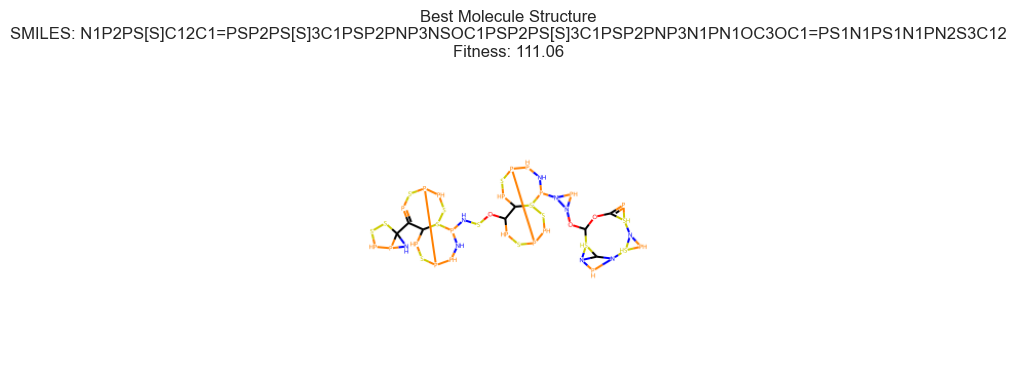

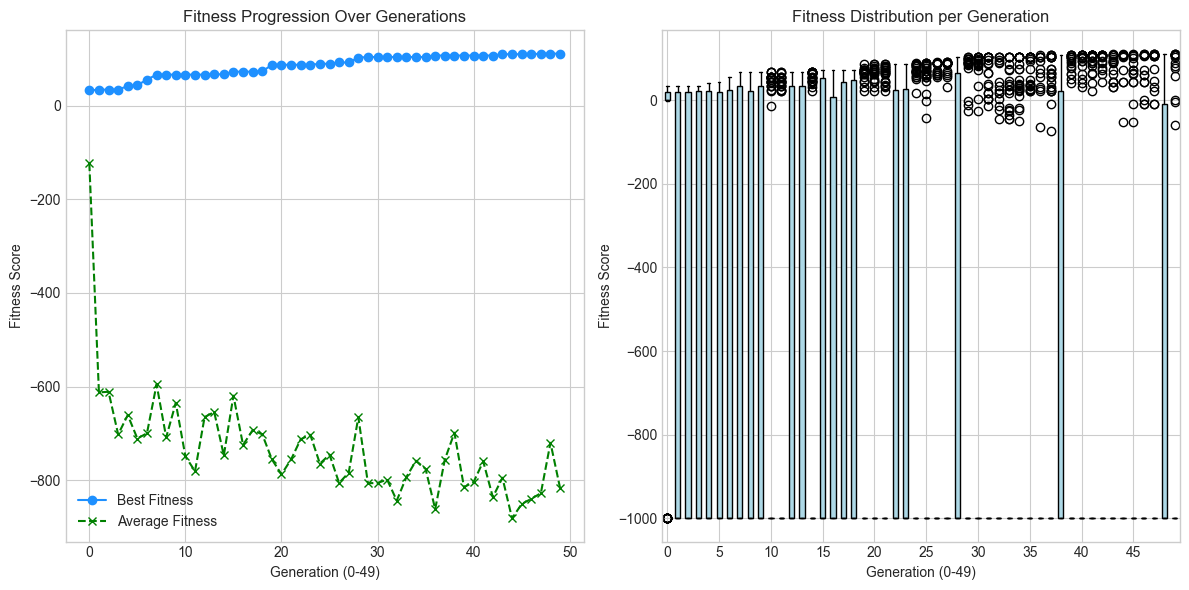

In [11]:
# --- GA Parameters ---
num_generations = 50
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = initial_pop

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_logp_fitness_2,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

In [12]:
def rdkit_qed_logp_fitness(smiles):
    """
    Calculates a fitness score based on LogP, QED (drug-likeness),
    molecular weight, ring presence, and connectivity.
    Higher QED (0-1) is better. QED is weighted by 10.
    Returns a very low score for invalid or highly undesirable SMILES.
    """
    if not smiles:
        return -1000.0

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0

    fitness_score = 0.0
    try:
        # 1. Base score from LogP
        fitness_score += Crippen.MolLogP(mol)

        # 2. Add QED score (weighted)
        qed_val = QED.qed(mol)
        fitness_score += qed_val * 10  # QED is 0-1, scale it up

        # 3. Check for connected molecule
        frags = Chem.GetMolFrags(mol, asMols=False)
        if len(frags) > 1:
            fitness_score -= 100  # Heavy penalty for disconnected molecules

        # 4. Molecular weight constraint (< 500 Da)
        mw = Descriptors.MolWt(mol)
        if mw < 500:
            fitness_score += 10 # Bonus
        else:
            fitness_score -= (mw - 500) / 10 # Penalize proportionally

        # 5. Ring presence (at least one ring)
        if mol.GetRingInfo().NumRings() > 0:
            fitness_score += 10*mol.GetRingInfo().NumRings()   # Bonus
        else:
            fitness_score -= 10   # Penalty
            
        # Penalize if too short or too long after other calcs
        if len(smiles) < 3 or len(smiles) > 100:
            return -1000.0
        
        return fitness_score
    except Exception:
        return -1000.0

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: 35.9127, SMILES: N1PP2PS[SH]12
Generation 2: Best this gen -> Fitness: 35.9127, SMILES: N1PP2PS[SH]12
Generation 3: New best -> Fitness: 36.4609, SMILES: C1PP2PS[SH]12
Generation 4: New best -> Fitness: 45.4923, SMILES: N1PP1PBN1PN2SC12
Generation 5: New best -> Fitness: 56.5093, SMILES: FC1PP2PS[SH]12N1PN2SC12
Generation 6: New best -> Fitness: 70.1325, SMILES: FOC1PP2PS[SH]12N1PPOP11PP2PS[SH]12
Generation 7: Best this gen -> Fitness: 70.1325, SMILES: FOC1PP2PS[SH]12N1PPOP11PP2PS[SH]12
Generation 8: Best this gen -> Fitness: 70.1325, SMILES: FOC1PP2PS[SH]12N1PPOP11PP2PS[SH]12
Generation 9: New best -> Fitness: 78.4201, SMILES: FOC1PP2PS[SH]121PP2PS[SH]12N1PN2SC12
Generation 10: Best this gen -> Fitness: 78.4201, SMILES: FOC1PP2PS[SH]121PP2PS[SH]12N1PN2SC12
Generation 11: Best this gen -> Fitness: 78.4201, SMILES: FOC1PP2PS[SH]121PP2PS[SH]12N1PN2SC12
Generation 12: Best this gen -> Fitness: 78

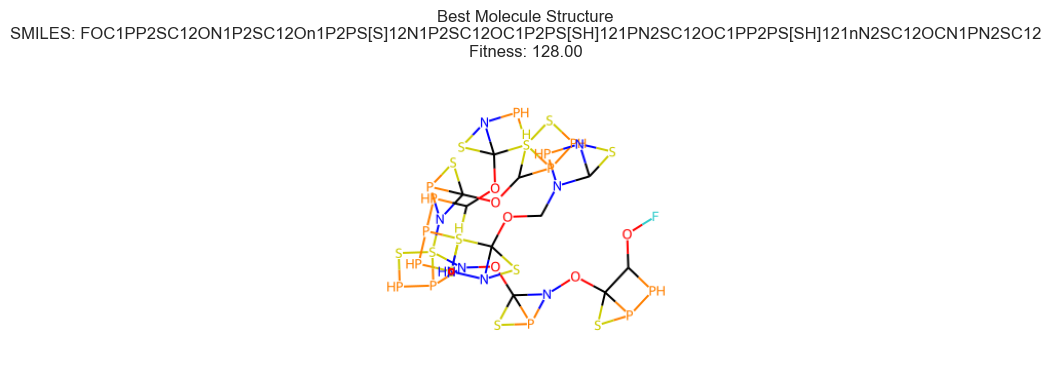

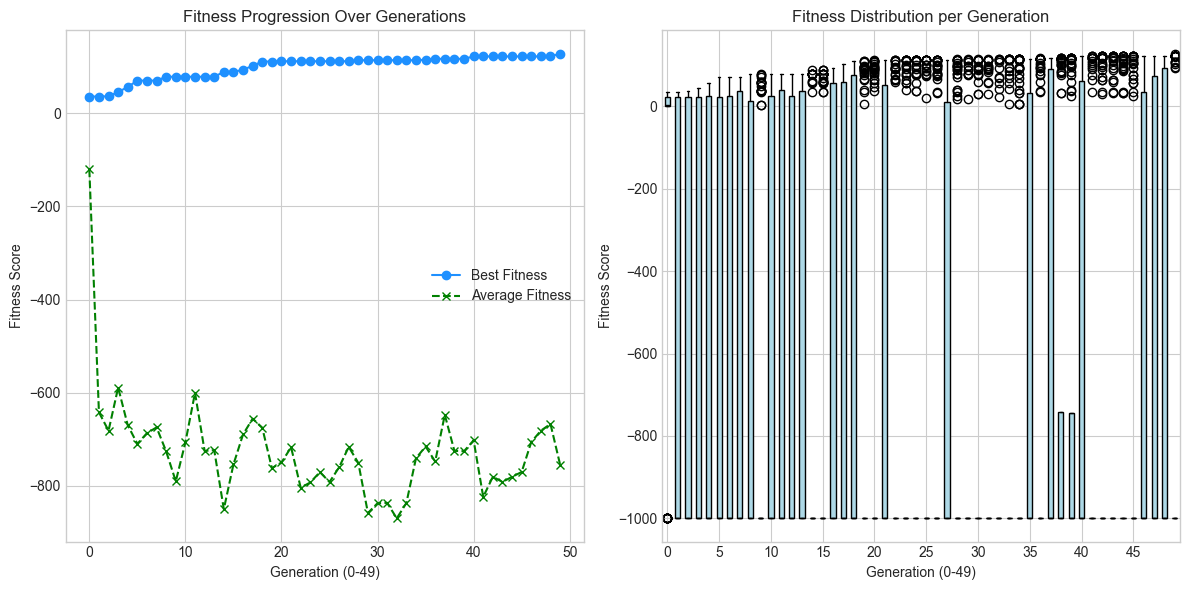

In [13]:
# --- GA Parameters ---
num_generations = 50
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = initial_pop

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_qed_logp_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

In [14]:
def rdkit_sa_qed_logp_fitness(smiles):
    """
    Calculates a fitness score based on LogP, QED, SAscore (synthetic accessibility),
    molecular weight, ring presence, and connectivity.
    Lower SAscore (1-10) is better. Term (5 - SAscore) * 2 is used.
    Returns a very low score for invalid or highly undesirable SMILES.
    """
    if not smiles:
        return -1000.0

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0

    fitness_score = 0.0
    try:
        logp_val = Crippen.MolLogP(mol)
        qed_val = QED.qed(mol)
        sa_val = sascorer.calculateScore(mol) # SAscore: 1 (easy) to 10 (hard)

        fitness_score = logp_val + (qed_val * 10) + ((5 - sa_val) * 2) # SA term: +8 to -10

        frags = Chem.GetMolFrags(mol, asMols=False)
        if len(frags) > 1: fitness_score -= 100
        
        mw = Descriptors.MolWt(mol)
        if mw < 500: fitness_score += 10
        else: fitness_score -= (mw - 500) / 10
        
        if mol.GetRingInfo().NumRings() > 0: 
            fitness_score += 10*mol.GetRingInfo().NumRings()   # Bonus
        else: 
            fitness_score -= 10
            
        # Penalize if too short or too long after other calcs
        if len(smiles) < 3 or len(smiles) > 100:
            return -1000.0
        
        return fitness_score
    except Exception:
        return -1000.0

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: 30.2997, SMILES: C1PP2PB12
Generation 2: New best -> Fitness: 39.1114, SMILES: BN1PN2SC12P1#[PH]PSNOO1
Generation 3: Best this gen -> Fitness: 39.1114, SMILES: BN1PN2SC12P1#[PH]PSNOO1
Generation 4: Best this gen -> Fitness: 39.1114, SMILES: BN1PN2SC12P1#[PH]PSNOO1
Generation 5: New best -> Fitness: 39.5694, SMILES: C1OS1C1OPP2PB12
Generation 6: New best -> Fitness: 44.3175, SMILES: CC1OP1C1OPP2PB12
Generation 7: Best this gen -> Fitness: 44.3175, SMILES: CC1OP1C1OPP2PB12
Generation 8: New best -> Fitness: 52.4190, SMILES: CCC1OPPOS1CC1OP1C1OPP2PB12
Generation 9: Best this gen -> Fitness: 52.4190, SMILES: CCC1OPPOS1CC1OP1C1OPP2PB12
Generation 10: New best -> Fitness: 60.1263, SMILES: CC1OP[PH]NS11POS1CC1OP1C1OPP2PB12
Generation 11: New best -> Fitness: 60.8841, SMILES: CC1OP[PH]NS11POS1CCCC1OP1C1OPP2PB12
Generation 12: New best -> Fitness: 61.6146, SMILES: CC1OP[PH]NS11OP11OP1C1OPP2PB12
Generat

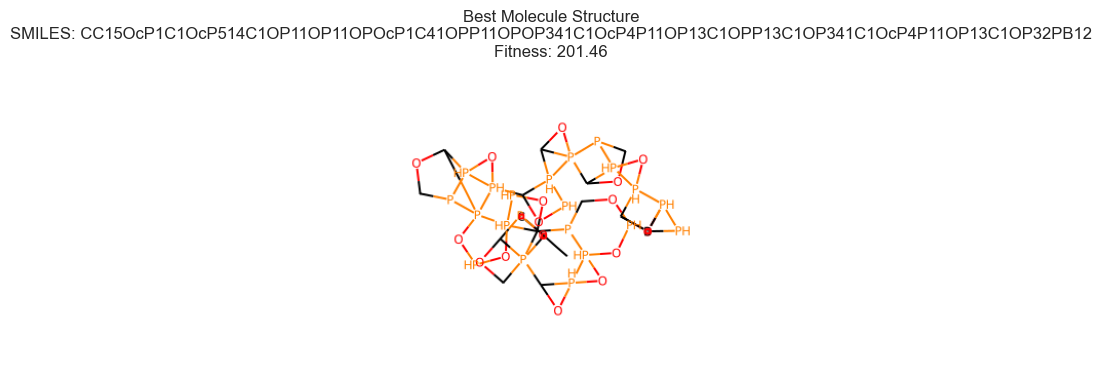

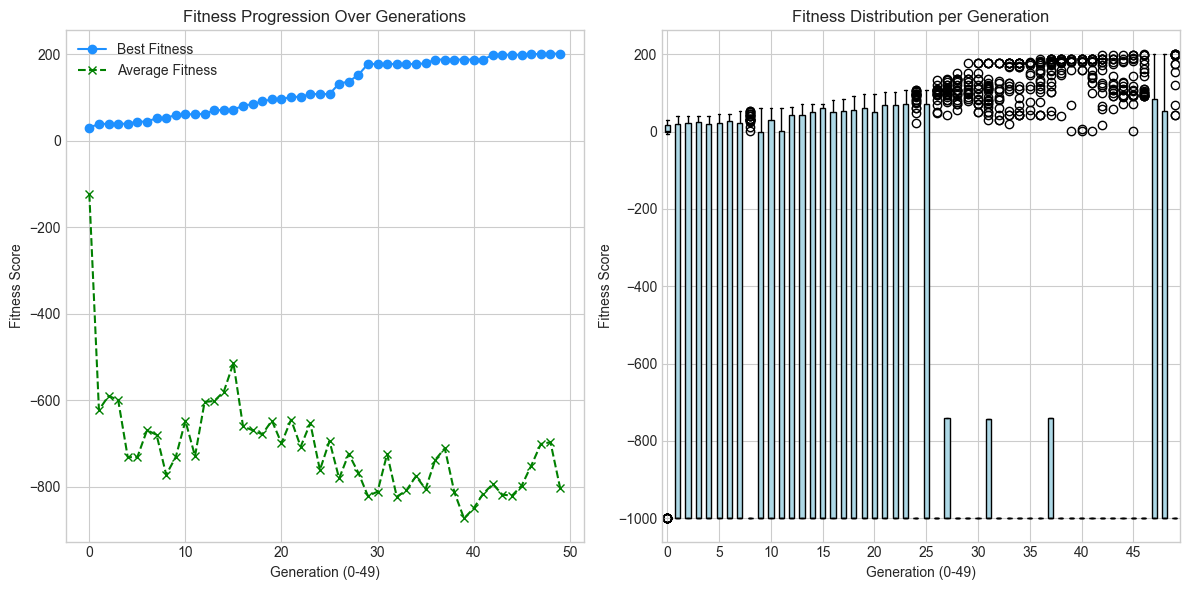

In [15]:
# --- GA Parameters ---
num_generations = 50
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = initial_pop

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_sa_qed_logp_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

/home/laplaza/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


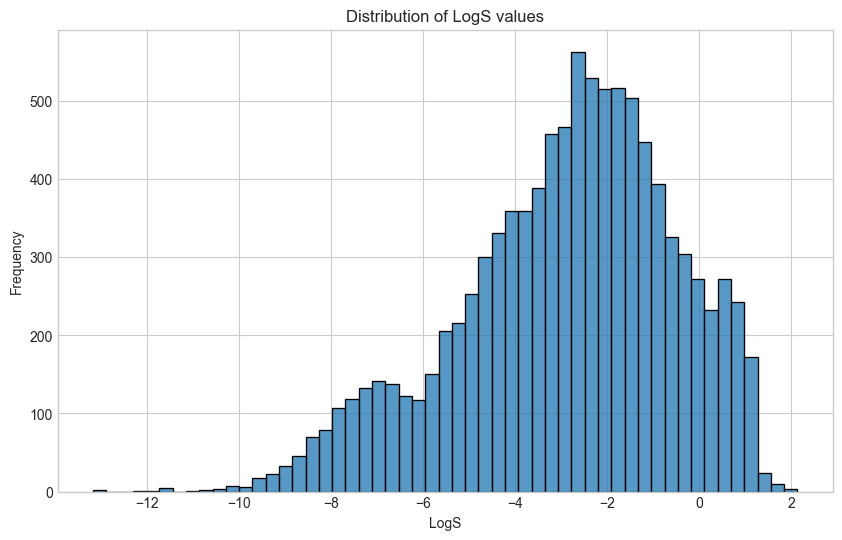

Model training and prediction complete.


In [16]:
sol_df = pd.read_csv('solubility_aqsoldb.tab', sep="\t")
sol_df = sol_df.rename(columns={"Drug": "SMILES", "Y": "LogS"}) # Thijs used ["Name","SMILES","LogS"]

# Prepare RDKit property calculator
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        # Optional: Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props

# Calculate properties and store them in the DataFrame
sol_df['props'] = sol_df['SMILES'].apply(smi2props)

# Critical fix: Remove rows where 'props' could not be calculated (are None)
sol_df.dropna(subset=['props'], inplace=True)

# Check if DataFrame is empty after dropping NaNs
if sol_df.empty:
    raise ValueError("DataFrame is empty after attempting to calculate properties and remove NaNs. Check SMILES validity and data.")

# Initialize the figure
plt.figure(figsize=(10, 6))

# Create the histogram
sns.histplot(sol_df['LogS'], kde=False)

# Customize the plot (optional)
plt.title('Distribution of LogS values')
plt.xlabel('LogS')
plt.ylabel('Frequency')

# Show the plot
plt.show()

train, test = train_test_split(sol_df, test_size=0.2, random_state=42)

# Critical fix: Convert Series of arrays into a 2D NumPy array for scikit-learn
# Also, ensure that there's data left to train on after filtering.
if train.empty or test.empty:
    raise ValueError("Training or test set is empty after filtering and splitting. Check data.")

train_X = np.vstack(train['props'].values)
train_y = train['LogS'].values
test_X = np.vstack(test['props'].values)
test_y = test['LogS'].values

rf2 = RandomForestRegressor(max_depth=10, n_estimators=100, max_features=0.2, random_state=42)

# train the model
rf2.fit(train_X, train_y)
# predict
pred = rf2.predict(test_X)

print("Model training and prediction complete.")
# Optional: from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(test_y, pred)
# print(f"Test MSE: {mse:.4f}")

def ml_fitness(smiles_string):
    """
    Fitness function that uses the trained RandomForestRegressor model (rf2)
    to predict a property (e.g., LogS) for a given SMILES string.

    Args:
        smiles_string (str): The SMILES string of the molecule.

    Returns:
        float: The predicted property value from the rf2 model.
               Returns a very low score (-1000.0) if the SMILES is invalid,
               properties cannot be generated, or prediction fails.
    """
    props = smi2props(smiles_string) # Uses the smi2props function defined above

    if props is None:
        return -1000.0  # SMILES invalid or properties could not be generated

    try:
        # The model expects a 2D array, so reshape/vstack the single props array
        predicted_value = rf2.predict(np.array([props]))
        return float(predicted_value[0]) # Return the first (and only) prediction
    except Exception:
        return -1000.0 # Fallback for any error during prediction


Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: 0.5911, SMILES: O=C(CO)CO
Generation 2: New best -> Fitness: 0.9881, SMILES: OC
Generation 3: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 4: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 5: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 6: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 7: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 8: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 9: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 10: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 11: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 12: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 13: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 14: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 15: Best this gen -> Fitness: 0.9881, SMILES: OC
Generation 16: Best this gen -> Fitness: 0.9881, SMIL

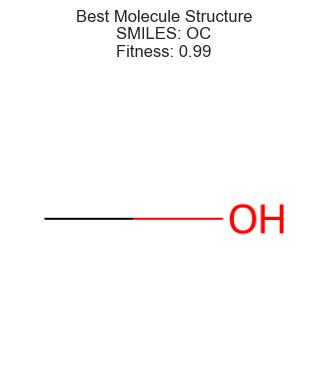

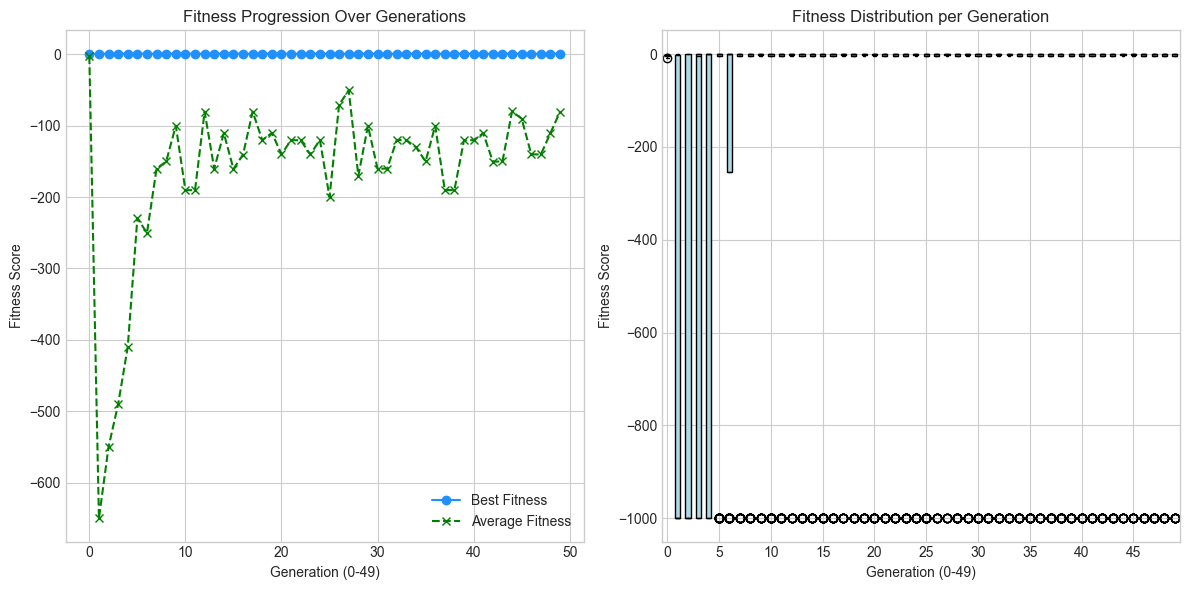

In [17]:
# --- GA Parameters ---
num_generations = 50
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = []
for i in range(pop_size):
    initial_pop.append(sol_df["SMILES"].values[random.randint(1,9000)])
print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=ml_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

In [18]:
def GaussianModifier(score, target, sigma=2) -> float:
    score = np.exp(-0.5 * np.power((score - target) / sigma, 2.0))
    return float(score)

def targeted_ml_fitness(smiles_string):
    """
    Fitness function that uses the trained RandomForestRegressor model (rf2)
    to predict a property (e.g., LogS) for a given SMILES string.

    Args:
        smiles_string (str): The SMILES string of the molecule.

    Returns:
        float: The predicted property value from the rf2 model.
               Returns a very low score (-1000.0) if the SMILES is invalid,
               properties cannot be generated, or prediction fails.
    """
    props = smi2props(smiles_string) # Uses the smi2props function defined above

    if props is None:
        return -1000.0  # SMILES invalid or properties could not be generated

    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        return -1000.0
    
    frags = Chem.GetMolFrags(mol, asMols=False)
    if len(frags) > 1: 
        return -1000.0
    
    mw = Descriptors.MolWt(mol)
    if mw < 500: 
        return -1000.0
        
    # Penalize if too short or too long after other calcs
    if len(smiles_string) < 3 or len(smiles_string) > 100:
        return -1000.0

    try:
        # The model expects a 2D array, so reshape/vstack the single props array
        predicted_value = rf2.predict(np.array([props]))
        return GaussianModifier(float(predicted_value[0]), -4) # Return the first (and only) prediction wrapped to target -4
    except Exception as e:
        print(e)
        return -1000.0 # Fallback for any error during prediction

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: 0.6713, SMILES: CCCCOC(=O)c1ccccc1N/N=C1\C(=O)C(C(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)=Cc2ccccc21
Generation 2: Best this gen -> Fitness: 0.6713, SMILES: CCCCOC(=O)c1ccccc1N/N=C1\C(=O)C(C(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)=Cc2ccccc21
Generation 3: Best this gen -> Fitness: 0.6713, SMILES: CCCCOC(=O)c1ccccc1N/N=C1\C(=O)C(C(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)=Cc2ccccc21
Generation 4: Best this gen -> Fitness: 0.6713, SMILES: CCCCOC(=O)c1ccccc1N/N=C1\C(=O)C(C(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)=Cc2ccccc21
Generation 5: Best this gen -> Fitness: 0.6713, SMILES: CCCCOC(=O)c1ccccc1N/N=C1\C(=O)C(C(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)=Cc2ccccc21
Generation 6: Best this gen -> Fitness: 0.6713, SMILES: CCCCOC(=O)c1ccccc1N/N=C1\C(=O)C(C(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)=Cc2ccccc21
Generation 7: Best this gen -> Fitness: 0.6713, SMILES: CCCCOC(=O)c1ccccc1N/N=C1\C(=O)C(C(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)=Cc2ccccc21
Generation 8: New best -> Fitness: 0

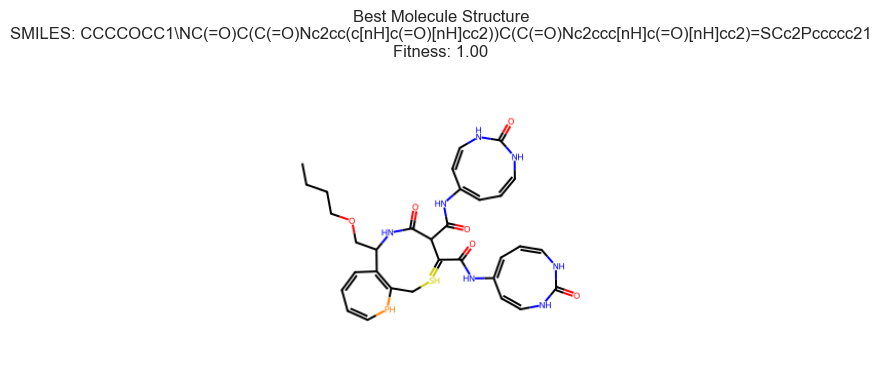

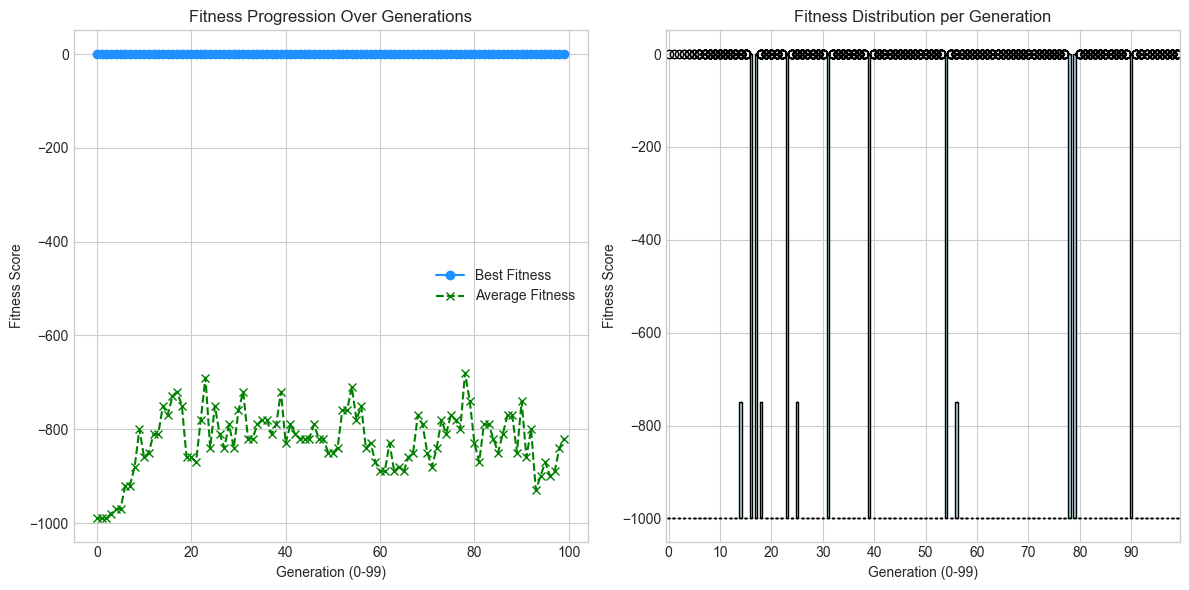

In [19]:
# --- GA Parameters ---
num_generations = 100
pop_size = 100
crossover_rate = 0.7
mutation_rate = 0.3 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = []
for i in range(pop_size):
    initial_pop.append(sol_df["SMILES"].values[random.randint(1,9000)])
print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=targeted_ml_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)